In [49]:
%matplotlib inline 
import pandas as pd
import numpy as np
import xarray as xr
import dask.array as da
import os
import glob
import time
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
# from statsmodels.distributions.empirical_distribution import ECDF

import seaborn as sns
sns.set_style('white')
sns.set_context("poster") #[poster, paper, talk, notebook]

import warnings; warnings.simplefilter('ignore') #not the best, but helps when zeros are out of hand

### functions

In [2]:
def ecdf(data):
    '''Computes Empirical CDF'''
    data = data.flatten()
    x = np.sort(data.flatten())
    f = np.arange(1, len(x)+1)/(len(x))
    return x, f

### example data

In [3]:
# # data = np.random.normal(1.5, 2, size=(200, 250))
# A=np.random.randn(200, 250)
# A.ravel()[np.random.choice(A.size, 20000, replace=False)] = np.nan
# print('number of nans', np.isnan(A).sum())
# data=A
# print(data.dtype)

# ix=~np.isnan(data)


# # print('data shape:', data.shape)
# # print('data type:', type(data))

# x, f = ecdf(data[ix])
# plt.plot(x, f, label="handwritten", marker=">", markerfacecolor='none')
# # ecdf = ECDF(data.flatten())
# # plt.plot(ecdf.x, ecdf.y, label="statmodels", marker="<", markerfacecolor='none')
# plt.legend()
# plt.show()

# bla = np.interp(data, x, f)
# print('interp data shape:', bla.shape)

# # plt.imshow(data); plt.show()
# # plt.imshow(bla); plt.show()

# real data
*NOTE: 
- data subregions, cm
- 20m dataset, mm

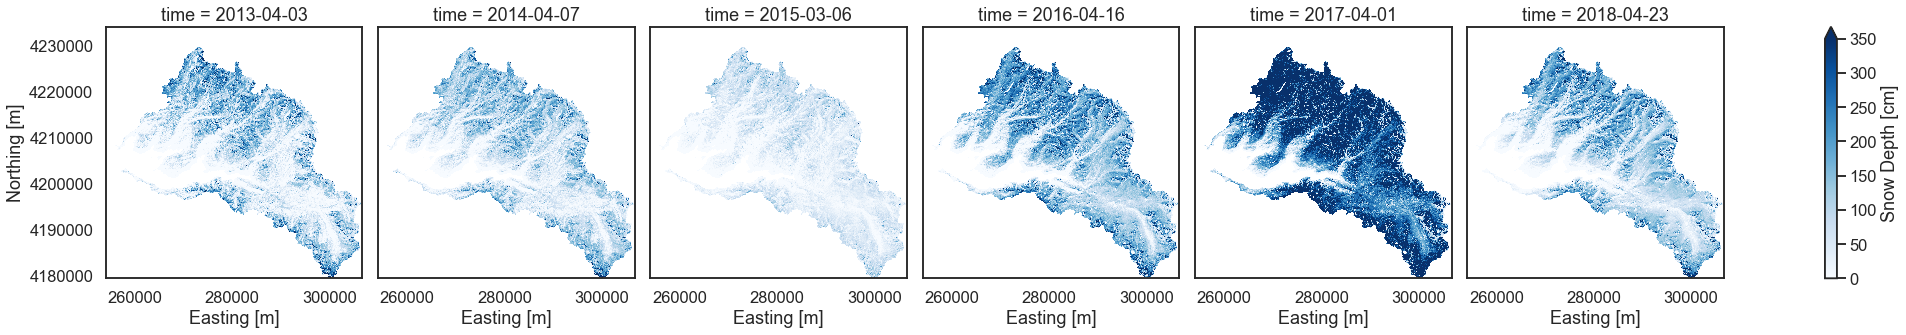

In [4]:
# fname = '~/Documents/research/sierra/data/compiled_SUPERsnow_3km_subregion.nc' #BSU
fname = '~/Documents/research/sierra/data/20m_analysis/compiled_SUPERsnow_20m.nc' 
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds['snow'] = ds.snow.where(ds.mask==1) #all snow inside the basin
ds['snow'] = ds.snow.where(ds.dem>=2000) #all snow at 2000m elev and above (~6500ft)
ds['snow'] = ds.snow.where(ds.snow>=0) #all snow >= zero
ds['snow'] = ds.snow/10 #to cm
ds.x.attrs['long_name']='Easting'; ds.x.attrs['units']='m'
ds.y.attrs['long_name']='Northing'; ds.y.attrs['units']='m'
ds = ds.isel(time=[0,7,18,30,42,49])
ds.close()

#quick data check
ds.snow.plot.imshow(x='x', y='y', col='time', col_wrap=6, cmap='Blues', vmax=350, cbar_kwargs={'label': 'Snow Depth [cm]'}, figsize=(30,5))

In [5]:
# #VERTICAL FIG

# for t in range(len(ds.time)):
    
#     #data
#     d = ds.snow[t].values #ndarray
#     l = ds['time.year'].values[t]
    
#     print('~~~YEAR:', l)
    
#     # emperical CDF
#     x, f = ecdf(d)
    
#     #interpolate ecdf function
#     dm = np.interp(d, x, f)
    
#     #plot 1): raw snow depth, 2):ecdf , 3) interp snow depth
    
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
    
#     h1 = ax1.imshow(ds.snow[t], cmap='Blues', vmax=250); fig.colorbar(h1, ax=ax1)
#     ax1.set_xlabel('Easting [m]'); ax1.set_ylabel('Northing [m]'); ax1.set_title('{} Snow Depth [cm]'.format(l))
#     ax1.set_aspect('auto')

    
#     ax2.plot(x, f, linewidth=4, label=l)
#     ax2.legend(loc='lower center')
#     ax2.set_xlim(0,1000)
#     ax2.set_xlabel('Snow Depth [cm]'); ax2.set_ylabel('Empirical CDF')
    
#     h3 = ax3.imshow(dm, cmap='coolwarm_r'); fig.colorbar(h3, ax=ax3)
#     ax3.set_xlabel('Easting [m]'); ax3.set_ylabel('Northing [m]'); ax3.set_title('{} Ecdf value at each cell [cm]'.format(l))
#     ax3.set_aspect('auto')


#     plt.tight_layout(h_pad=1)
# #     plt.show()
# # plt.savefig('../figs/ack_peak_ecdf_vert.png', dpi=300)#, transparent=True


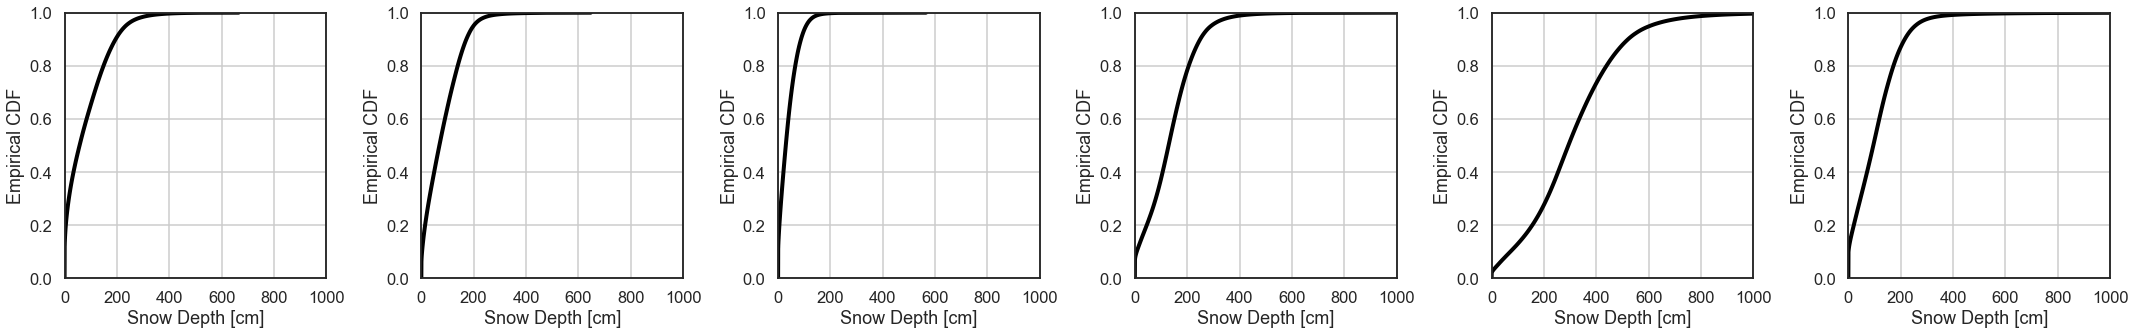

In [6]:
# Empiricial CFD Plot and compute interp ECDF map
ecdf_holder = np.zeros((len(ds.time), len(ds.y), len(ds.x)))
# print(ecdf_holder.shape)
# print(ds.snow.shape)
# d

plt.subplots(1, 6, figsize=(30,5))

for t in range(len(ds.time)):

    #data
    d = ds.snow[t].values #ndarray
    ix = ~np.isnan(d)
    l = ds['time.year'].values[t]
    
    # emperical CDF
    x, f = ecdf(d[ix])

    #interpolate ecdf function
    dm = np.interp(d, x, f)
    #add to xarray
    ecdf_holder[t,:,:] = dm
    
    plt.subplot(1,6,t+1)
    plt.plot(x, f, color='k', linewidth=4, label=l)
#     plt.legend(loc='lower center')
    plt.xlim(0,1000)
    plt.ylim(0,1)
    plt.xlabel('Snow Depth [cm]'); plt.ylabel('Empirical CDF')
    plt.grid()
plt.tight_layout()
# plt.savefig('../figs/TB_peak_ecdf.png', dpi=300)#, transparent=True

#ADD VARIABLE TO XARRAY DATASET
ds['ecdf_snow'] = (('time', 'y','x'), da.from_array(ecdf_holder, chunks=(1, 1000, 1000)))


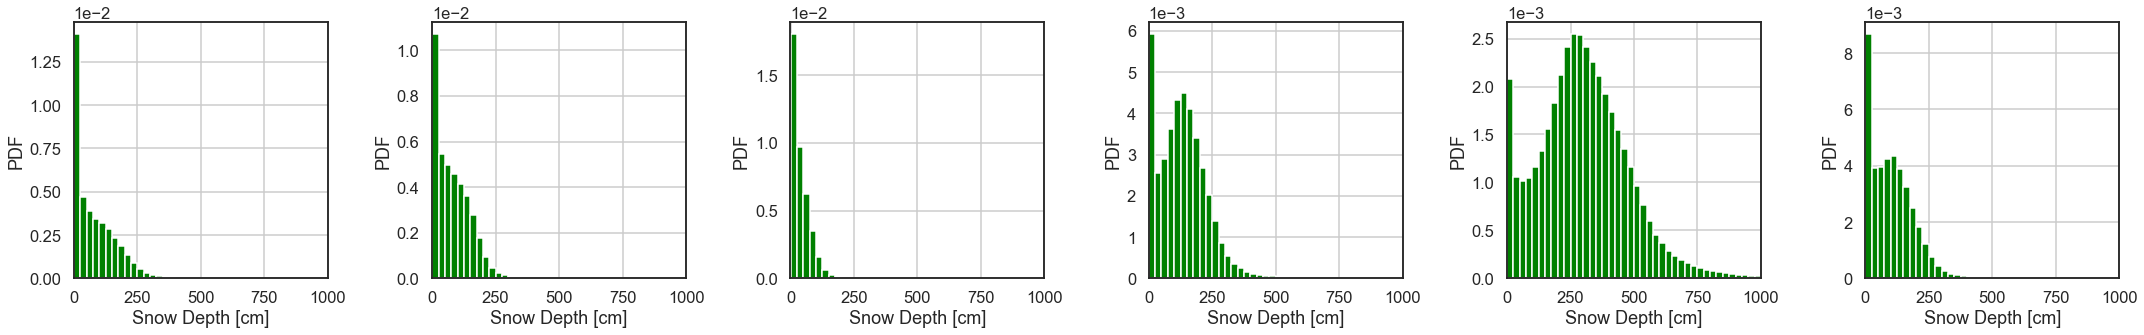

In [31]:
#PDFs
plt.subplots(1, 6, figsize=(30,5))

for t in range(len(ds.time)):

    #data
    d = ds.snow[t].values #ndarray
    ix = ~np.isnan(d)
    l = ds['time.year'].values[t]
    plt.subplot(1,6,t+1)
    plt.hist(d[ix], bins=np.arange(np.min(d[ix]),np.max(d[ix]),25), density=True, color='g')
    plt.xlabel('Snow Depth [cm]'); plt.ylabel('PDF')
    plt.xlim(-1,1000)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.grid()
#     plt.tight_layout()
#     plt.savefig('../figs/TB-{}_peak_pdf_ecdf.png'.format(l), dpi=300)
plt.tight_layout()


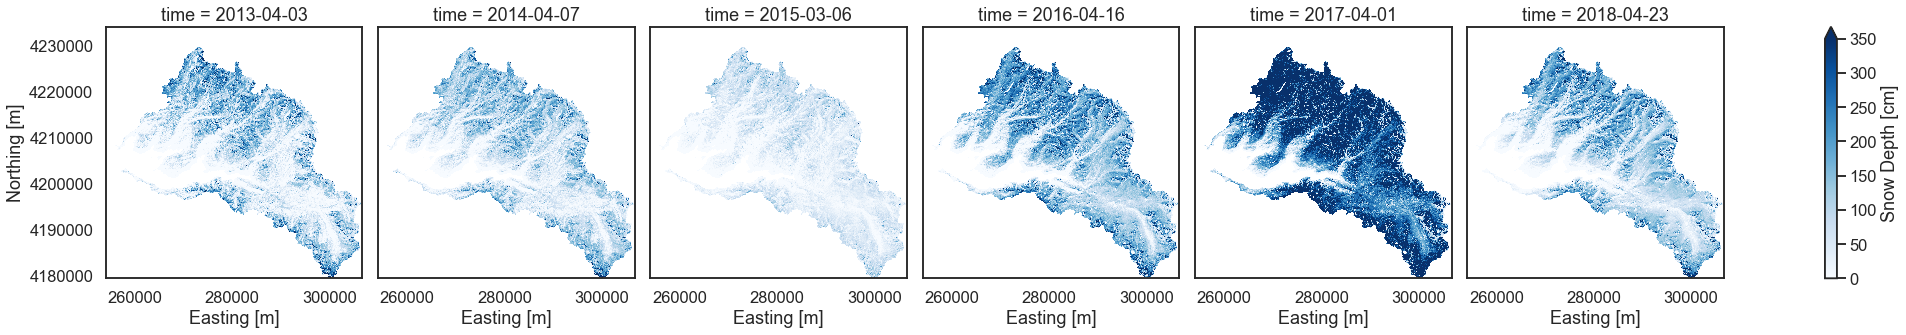

In [7]:
# raw snow depth plot
# ds['time'] = ds['time'].dt.strftime('%d-%b-%Y')
ds.snow.plot.imshow(x='x', y='y', col='time', col_wrap=6, cmap='Blues', vmax=350, cbar_kwargs={'label': 'Snow Depth [cm]'}, figsize=(30,5))
# plt.savefig('../figs/TB_peak_sdRaw.png', dpi=300)#, transparent=True

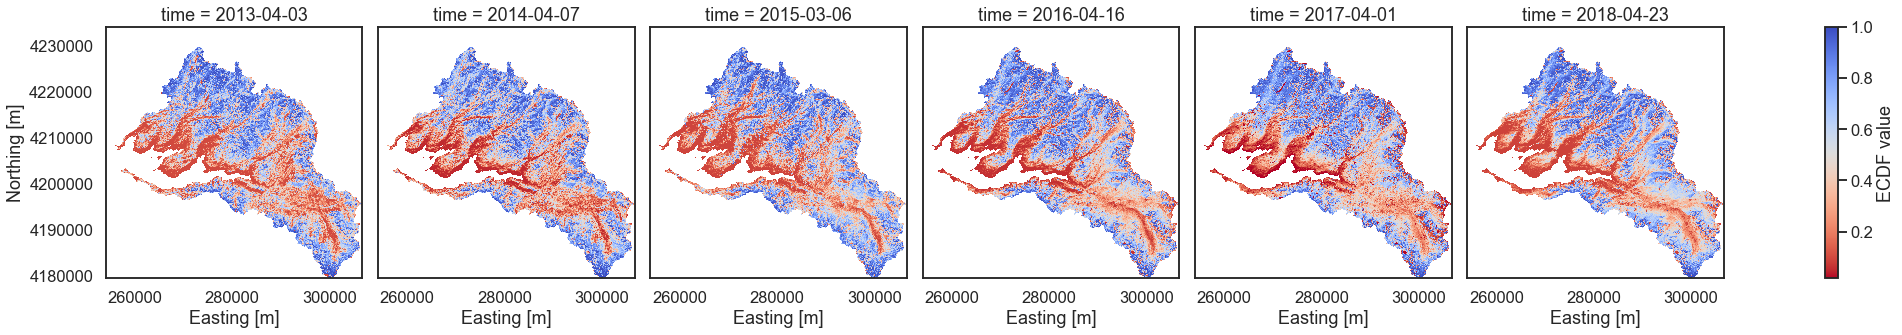

In [8]:
ds.ecdf_snow.plot.imshow(x='x', y='y', col='time', col_wrap=6, cmap='coolwarm_r', vmax=1, cbar_kwargs={'label': 'ECDF value'}, figsize=(30,5))
# plt.savefig('../figs/TB_peak_ecdfMap.png', dpi=300)

### further analysis

In [32]:
ds

<xarray.Dataset>
Dimensions:    (time: 6, x: 2637, y: 2739)
Coordinates:
  * x          (x) float32 254000.0 254020.0 254040.0 ... 306700.0 306720.0
  * y          (y) float32 4234060.0 4234040.0 4234020.0 ... 4179320.0 4179300.0
  * time       (time) datetime64[ns] 2013-04-03 2014-04-07 ... 2018-04-23
    mask       (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem        (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg        (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Data variables:
    snow       (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ecdf_snow  (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

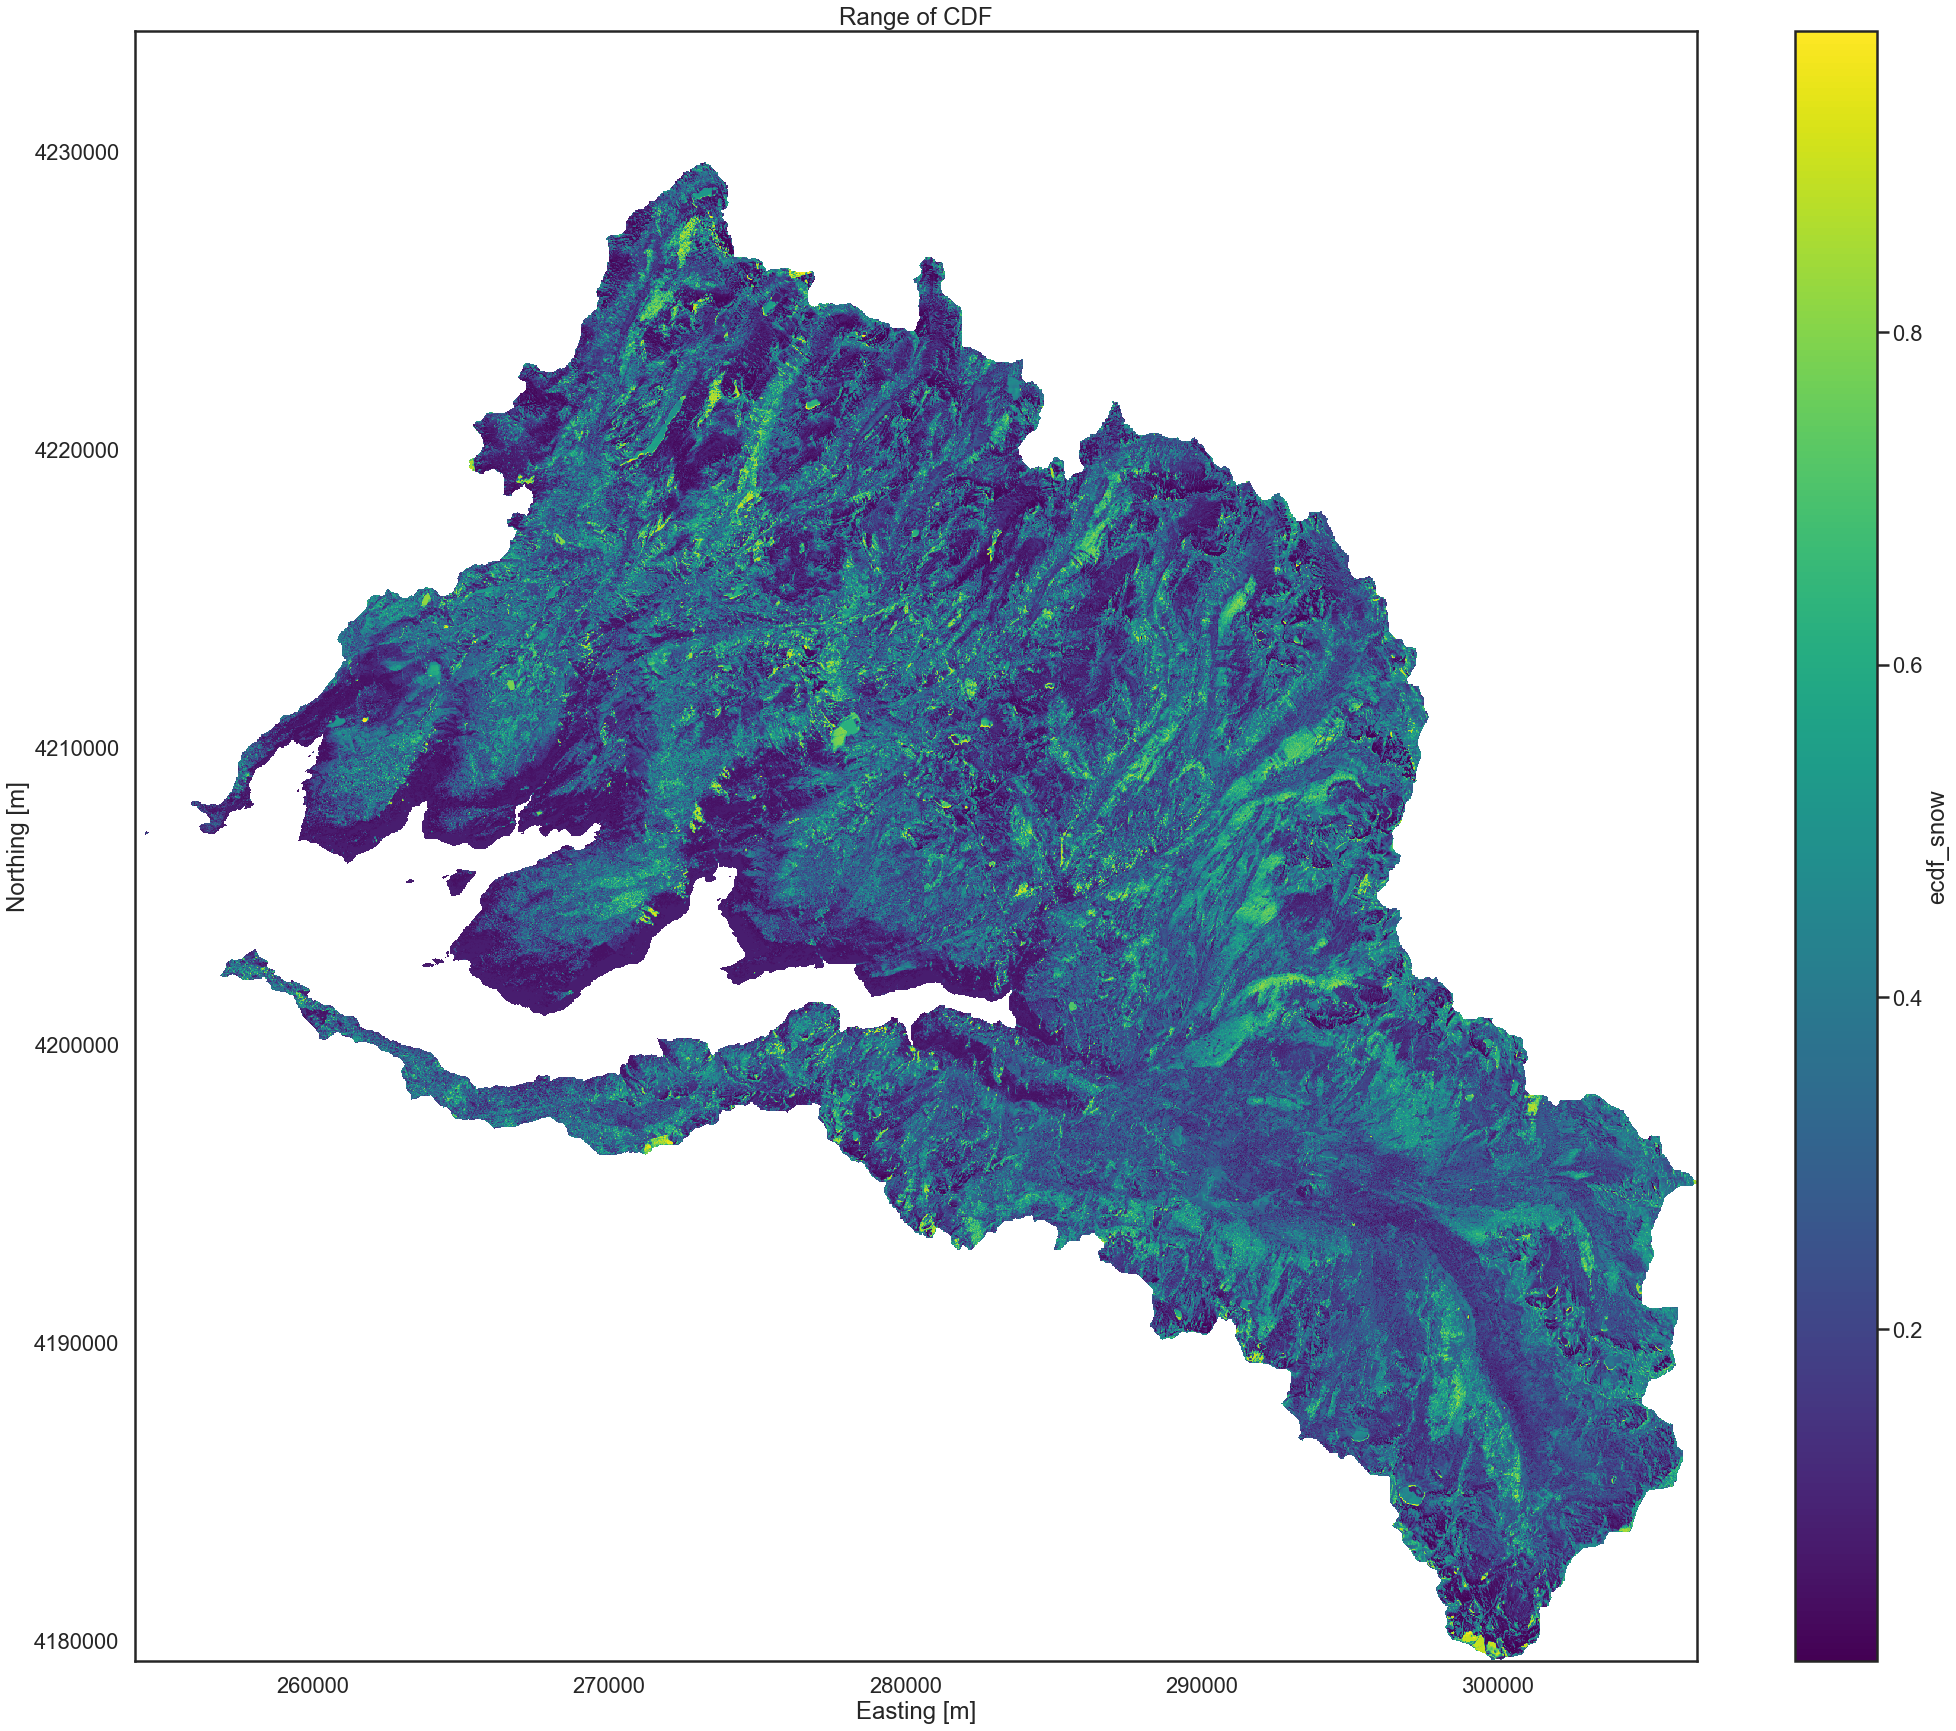

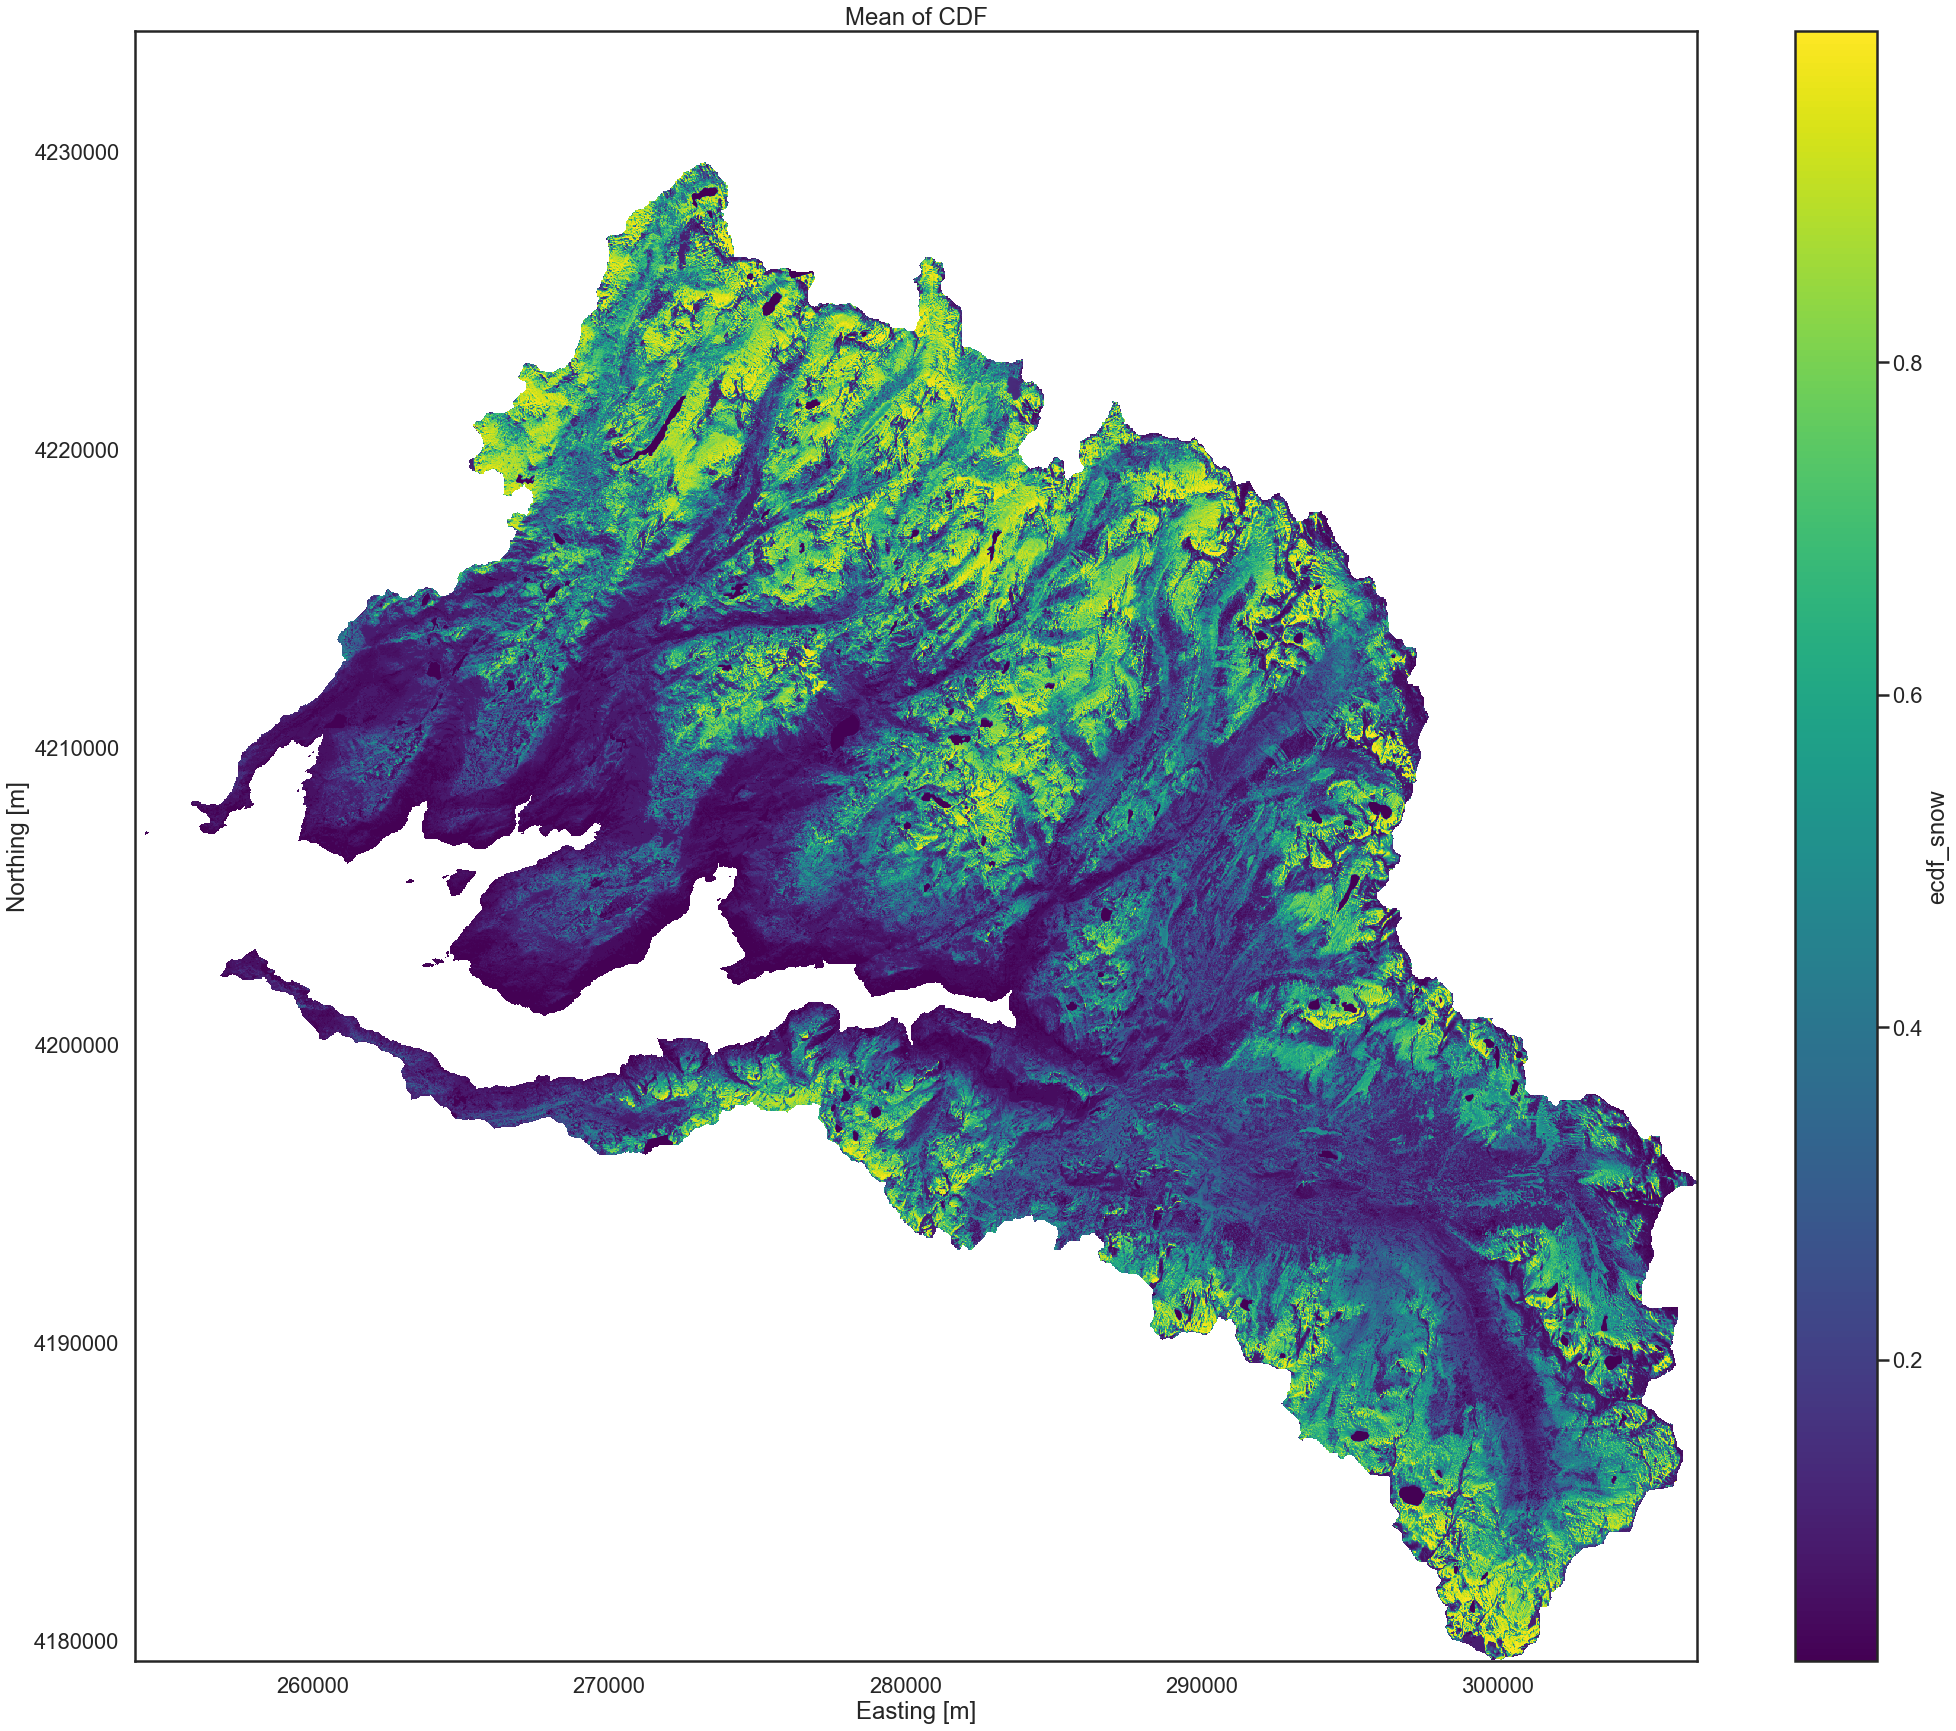

In [50]:
mx = ds.ecdf_snow.max(dim='time')
mn = ds.ecdf_snow.min(dim='time')
rn = mx - mn
rn.plot.imshow(figsize=(35,30)); plt.title('Range of CDF')
plt.savefig('../figs/TB_peak_range_ecdf.png', dpi=300)

mu = ds.ecdf_snow.mean(dim='time')
mn.plot.imshow(figsize=(35,30)); plt.title('Mean of CDF')
plt.savefig('../figs/TB_peak_mean_ecdf.png', dpi=300)

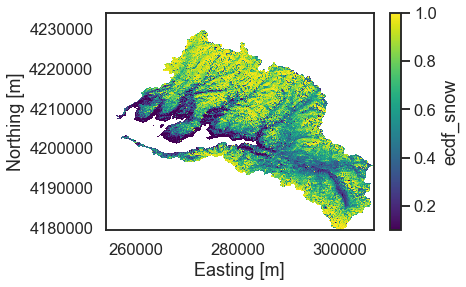

In [35]:
mx.plot.imshow()

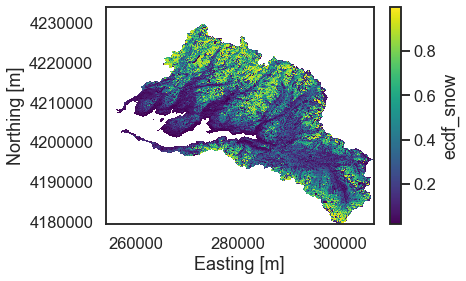

In [36]:
mn.plot.imshow()

array(0.09908361)